# SegCaps on Image Segmentation for Person

A quick intro to using the pre-trained model to detect and segment object of person.

In [1]:
from os import path
import sys
import random
import math

import warnings
warnings.filterwarnings('ignore')

import SimpleITK as sitk
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import sys

from keras.utils import print_summary
# Add the ptdraft folder path to the sys.path list
sys.path.append('../')

import capsnet as modellib
from data_helper import *
from test import *
from PIL import Image


%matplotlib inline 

RESOLUTION = 512

# Root directory of the project
ROOT_DIR = path.dirname("../")
DATA_DIR = path.join(ROOT_DIR, "data")

# Directory to save logs and trained model
MODEL_DIR = path.join(DATA_DIR, "saved_models/segcapsr3/m1.hdf5") # LUNA16

# Local path to trained weights file
COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/m4c.hdf5") # MSCOCO17

# Directory of images to run detection on
IMAGE_DIR = path.join(DATA_DIR, "imgs")

Using TensorFlow backend.


## Create Model and Load Trained Weights

In [2]:
# Create model object in inference mode.
net_input_shape = (RESOLUTION, RESOLUTION, 1)
num_class = 2
train_model, eval_model, manipulate_model = modellib.CapsNetR3(net_input_shape, num_class)


# Load weights trained on MS-COCO
eval_model.load_weights(COCO_MODEL_PATH)
print_summary(model=eval_model)



Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 16) 416         input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 512, 512, 1,  0           conv1[0][0]                      
__________________________________________________________________________________________________
primarycaps (ConvCapsuleLayer)  (None, 256, 256, 2,  12832       reshape

In [3]:
import scipy.ndimage.morphology
from skimage import measure, filters

def threshold_mask(raw_output, threshold):
    if threshold == 0:
        try:
            threshold = filters.threshold_otsu(raw_output)
        except:
            threshold = 0.5

    print('\tThreshold: {}'.format(threshold))

    raw_output[raw_output > threshold] = 1
    raw_output[raw_output < 1] = 0

    all_labels = measure.label(raw_output)
    props = measure.regionprops(all_labels)
    props.sort(key=lambda x: x.area, reverse=True)
    thresholded_mask = np.zeros(raw_output.shape)

    if len(props) >= 2:
        if props[0].area / props[1].area > 5:  # if the largest is way larger than the second largest
            thresholded_mask[all_labels == props[0].label] = 1  # only turn on the largest component
        else:
            thresholded_mask[all_labels == props[0].label] = 1  # turn on two largest components
            thresholded_mask[all_labels == props[1].label] = 1
    elif len(props):
        thresholded_mask[all_labels == props[0].label] = 1

    thresholded_mask = scipy.ndimage.morphology.binary_fill_holes(thresholded_mask).astype(np.uint8)

    return thresholded_mask


## Predict the Segmentation of Person



In [4]:
from datetime import datetime

img = ['train4.png']
output_array = None


sitk_img = sitk.ReadImage(join(IMAGE_DIR, img[0]))
img_data = sitk.GetArrayFromImage(sitk_img)
    
generate_test_batches = get_test_batches_generator('mscoco17')
print(str(datetime.now()))
output_array = eval_model.predict_generator(generate_test_batches(DATA_DIR, [img],
                                                                  net_input_shape,
                                                                  batchSize=1,
                                                                  numSlices=1,
                                                                  subSampAmt=0,
                                                                  stride=1),
                                            steps=1, max_queue_size=1, workers=1,
                                            use_multiprocessing=False, verbose=1)
print(str(datetime.now()))

2018-06-22 09:17:45.552978
load_2D_data.generate_test_batches
load_2D_data.generate_test_batches: test_list=[['train4.png']]
1/1 [==============================] - 71s 71s/step
2018-06-22 09:18:56.202196


In [5]:
# output_array contain 2 masks in a list, show the first element.
# print('len(output_array)=%d'%(len(output_array)))
# print('test.test: output_array=%s'%(output_array[0]))


In [6]:
# output = (1, 512, 512)
output = output_array[0][:,:,:,0] # A list with two images, get first one image and reshape it to 3 dimensions.
recon = output_array[1][:,:,:,0]
# image store in tuple structure.
# print('test.test: output=%s'%(output))
np.ndim(output)
np_output = np.array(output)





In [7]:
# output_img = sitk.GetImageFromArray(output[0,:,:], isVector=True)

print('Segmenting Output')

# output_bin = threshold_mask(output, threshold_level)
output2d = output[0,:,:]
# output2d = recon[0,:,:]
# print(output2d)

Segmenting Output


threshold_level=0.900000


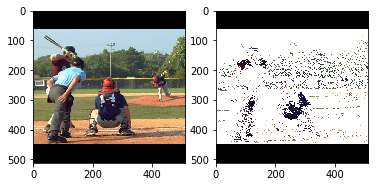

In [17]:
threshold_level = 0.9
mask = output2d[...] > threshold_level


# Set all masked pixels to zero
masked = img_data.copy()
masked[mask] = 0
# print(masked)
# output_mask = sitk.GetImageFromArray(output_bin[0,:,:], isVector=True)
#     output_img = np.reshape(output_img, [512, 512, 1])
#     output_mask = np.reshape(output_mask, [512, 512, 1])

# Display original and masked images side-by-side
print('threshold_level=%f'%threshold_level)
plt.figure()
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(img_data)
ax1.imshow(masked)
plt.show()

##### 